In [ ]:
#インポートなど
import matplotlib
from matplotlib import cm
from matplotlib import animation
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys,os
import tqdm
import random
from IPython.display import HTML

In [ ]:
import descent_method_2d as dm
import differentiable_benchmark_func as dbf

In [ ]:
%matplotlib notebook

In [ ]:
cmap_list=list(cm.cmap_d.values())
def get_random_cm():
    return random.choice(cmap_list)
get_random_cm()

In [ ]:
X=None
Y=None
Z=None
prev_f=None
def draw_function(f:dbf.BenchmarkFunction,cmap,elev=50,azim=30):
    '''
    2次元関数を描画する。
    Returns
    -------
    fig : Figure
    ax : Axes3D
    '''
    if cmap is not None:print('cmap={}'.format(cmap.name))
    global X,Y,Z,prev_f
    facecolor=(.9,.9,.9)
    
    fig=plt.figure(facecolor=facecolor,dpi=100,figsize=(6.4,4.8))
    fig.suptitle(f.NAME)
    ax=fig.gca(projection='3d')
    ax.set_facecolor(facecolor)
    ax.view_init(elev,azim)
    
    ax.set_xlabel('x')
    ax.set_xlim(f.DOMAIN[0])
    ax.set_ylabel('y')
    ax.set_ylim(f.DOMAIN[1])
    ax.set_zlabel('z')
    
    if f is not prev_f:
        X=np.linspace(f.DOMAIN[0][0],f.DOMAIN[0][1],100)
        Y=np.linspace(f.DOMAIN[1][0],f.DOMAIN[1][1],100)
        X,Y=np.meshgrid(X,Y)
        Z=np.asarray(f.__call__(np.array([X,Y])))
    
    ax.plot_wireframe(X,Y,Z,alpha=0.6,rcount=30,ccount=30,linewidth=0.8,colors=(0,0,0))
    #if cmap is not None:ax.contour(X,Y,Z,zdir='z',cmap=cmap,offset=Z.min())
    ax.plot_surface(X,Y,Z,alpha=0.3,cmap=cmap)
    
    for w in f.MINW:
        ax.scatter(w[0],w[1],f.__call__(np.asarray(w)),marker='*',color=(0,0,0),s=100,alpha=0.5)
    
    return (fig,ax)
#fig,ax=draw_function(f,get_random_cm())

In [ ]:
import importlib
importlib.reload(dm)
importlib.reload(dbf)

In [60]:
f=dbf.Exponential()

cmap=gist_ncar


<IPython.core.display.Javascript object>


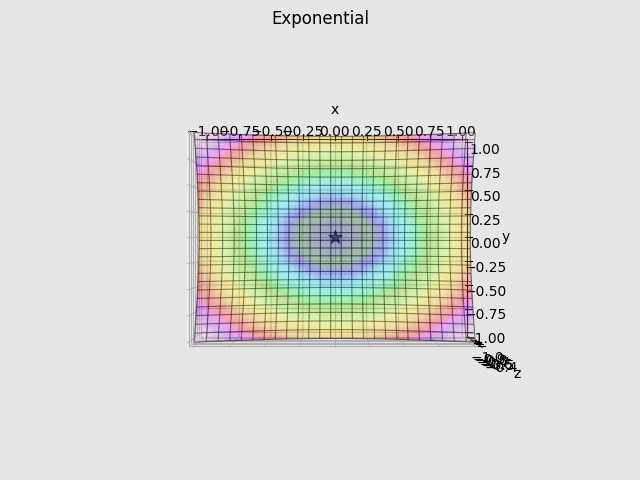

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7fc338e8bda0>)

In [61]:
draw_function(f,get_random_cm(),90,-90)

In [64]:
w_0=[.8,-.3]
step=500
optimizer_list=[
    #dm.StochasticGradientDescent(0.01),
    #dm.MomentumSGD(0.01),
    dm.NesterovAcceleratedGradient(0.01),
    dm.AdaGrad(.1),
    dm.RMSprop(.1),
    #dm.AdaDelta(0.99),
    dm.Adam(.1),
    dm.AMSGrad(.1)
]
color_list=cm.Set1(np.linspace(0,1,len(optimizer_list)))
log_d={}
for optimizer,color in zip(optimizer_list,color_list):
    w,x_log,y_log=optimizer.execute(f,np.asarray(w_0,dtype=np.float),step)
    z_log=f(np.asarray([x_log,y_log]))
    log={'x':x_log,'y':y_log,'z':z_log,'color':color}
    log_d[optimizer.name]=log
#log_d

<IPython.core.display.Javascript object>


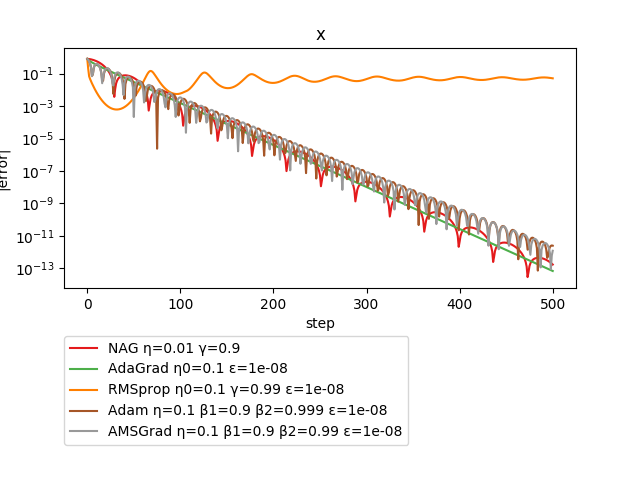

In [65]:
#エラー履歴
param='x'
if param=='x':answer=f.MINW[0][0]
if param=='y':answer=f.MINW[0][1]
if param=='z':answer=f(f.MINW[0])

fig=plt.figure()
ax2=fig.add_axes([.1,.4,.8,.5],anchor='S')
s=np.array(range(step+1))
for name,log in log_d.items():
    error_log=np.abs(np.asarray(log[param])-answer)
    ax2.plot(s,error_log,label=name,color=log['color'])
    ax2.legend(bbox_to_anchor=(0,-.2),loc='upper left',borderaxespad=0.)
ax2.set_xlabel('step')
ax2.hlines(0,0,step,linestyles=':',linewidth=0.3)
ax2.set_title(param)
ax2.set_ylabel('|error|')
ax2.set_yscale('log')
fig.show()

cmap=coolwarm


<IPython.core.display.Javascript object>


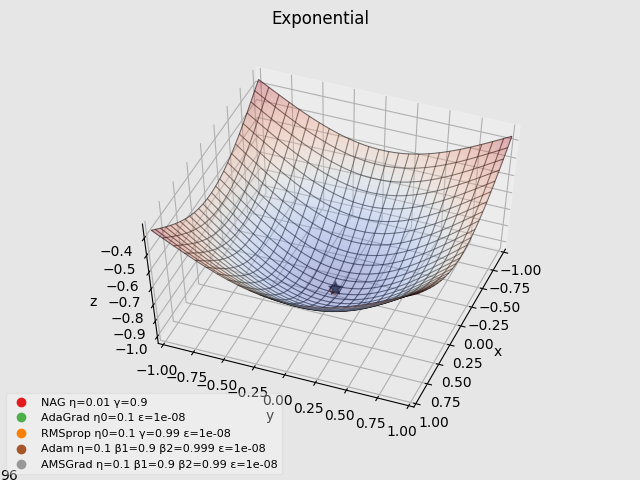

In [66]:
#球の移動履歴アニメ
fig,ax=draw_function(f,cm.coolwarm,ax.elev,ax.azim)
anime_frames=[]
handle_list=[]
for i in range(step):
    i0=max(0,i-4)
    frame=[]
    frame.append(fig.text(0,0,str(i)))
    for log in log_d.values():
        x_log=log['x']
        y_log=log['y']
        z_log=log['z']
        color=log['color']
        plot,=ax.plot([x_log[i]],[y_log[i]],[z_log[i]],marker='o',linestyle='',color=color)
        trail,=ax.plot(x_log[i0:i+1],y_log[i0:i+1],z_log[i0:i+1],marker='',linestyle=':',color=color,linewidth=1.3)
        frame.append(plot)
        frame.append(trail)
        if i==0:handle_list.append(plot)
    anime_frames.append(frame)
fig.legend(handle_list,list(log_d.keys()),fontsize=8,loc='lower left',framealpha=0.3)
anime=animation.ArtistAnimation(fig,anime_frames,interval=80)

cmap=Greys_r


<IPython.core.display.Javascript object>


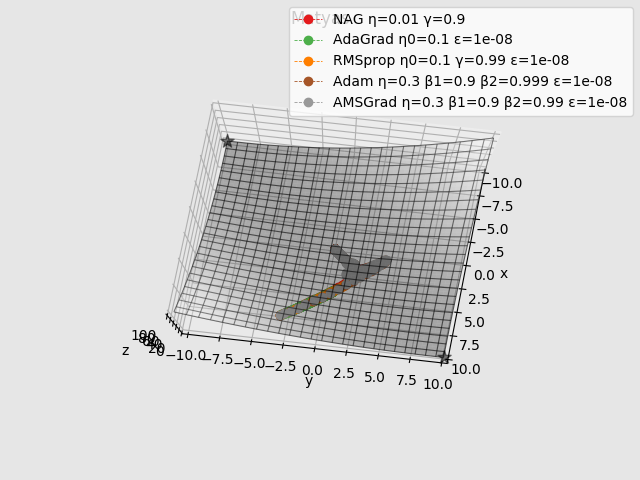

In [57]:
#軌跡を線で表す
fig,ax=draw_function(f,cm.Greys_r,ax.elev,ax.azim)
for name,log in log_d.items():
    x_log=log['x']
    y_log=log['y']
    z_log=log['z']
    color=log['color']
    ax.plot(x_log,y_log,z_log,marker='o',linewidth=.6,label=name,linestyle='--',color=color)
fig.legend()
fig.show()

In [ ]:
def save_movie(comment):
    file_name='{}opts at ({},{}) on {}{}.gif'.format(len(optimizer_list),w_0[0],w_0[1],f.NAME,comment)
    print(file_name)
    anime.save(file_name)
    print('finished!')

# Duplicated

In [ ]:
#軌跡を点で表す
line={}#key : 最適化の名称 value : その最適化での変数履歴を示すline
fig,ax=draw_function(f,cm.YlGnBu,ax.elev,ax.azim)
def animate(i):
    fig.suptitle(str(i))
    for name,my_log in log_d.items():
        my_line=line[name]
        my_x=my_log['x'][i]
        my_y=my_log['y'][i]
        my_z=my_log['z'][i]
        my_line.set_color(my_log['color'])
        my_line.set_data_3d(my_x,my_y,my_z)
    
for name in log_d.keys():
    line[name],=ax.plot([],[],[],marker='o',label=name,linestyle='')

fig.legend(loc='upper left')
fig.show()
ani=animation.FuncAnimation(fig,animate,len(z_log),interval=100,save_count=len(z_log))

In [ ]:
ani.save('movie.gif')